# Python 3.10.13 사용

1. 문제 정의 : 
         치매는 환자뿐만 아니라 가족, 치료자, 사회 전체에도 큰 부담을 주는 질환입니다. 
        치매와 관련된 정보를 바탕으로 사회적, 경제적 대응 전략을 수립하고, 리소스를 효율적으로 분배하는 데 도움이 될 수 있습니다.
        그 중에 이번에 분석 할 내용은 치매와 나이와의 연관성입니다.
    
    

2. 데이터 선택 :  
    1) 공공데이터 - 보건복지부_시군구별 치매 현황 (자료 이름)
    2) https://www.data.go.kr/data/15073342/fileData.do  (링크)

In [1]:
#seaborn 설치, 데이터 시각화, 데이터 조작, 클러스터링, 전처리등을 위한 라이브러리 import
%pip install seaborn            
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.font_manager as fm

Note: you may need to restart the kernel to use updated packages.


In [2]:
#csv데이터 읽어오기
df = pd.read_csv("./보건복지부_시군구별 치매현황_20221231.csv")

3. 데이터 전처리 : 결측치 및 중복 데이터, 사용하지 않는 데이터 제외 시키기
    1) 결측치가 있는지 확인하기 위해 df.info()를 사용하여 정보 확인
    2) '~'로 표현되어있는 연령범위와 **세이상으로 표현되어 있는 연령범위중 중복되는 부분 제외시키기
    3) 각 지역과 전국이 동시에 존재해 중복되는 부분 제외
    4) 알 수 없는 데이터인 남계, 여계 제외시킨 후 연령별 치매환자유병률(나이와 치매질병간의 관계)에 관한 데이터 시각화
    5) 치매환자유병률 열의 데이터를 표준화. (StandardScaler를 사용하여 데이터의 평균을 0, 표준편차를 1로 만듬)

In [3]:
#데이터 내용확인 및 전처리를 위한 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20412 entries, 0 to 20411
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   시점            20412 non-null  int64  
 1   행정구역(시도)별     20412 non-null  object 
 2   행정구역(기초)별     20412 non-null  object 
 3   성별            20412 non-null  object 
 4   연령별           20412 non-null  object 
 5   노인인구수         20412 non-null  float64
 6   치매환자수         20412 non-null  float64
 7   치매환자유병률       20412 non-null  float64
 8   최경도 환자        20412 non-null  float64
 9   경도 환자         20412 non-null  float64
 10  중등도 환자        20412 non-null  float64
 11  중증 환자         20412 non-null  float64
 12  알츠하이머 환자수     13740 non-null  float64
 13  알츠하이머 환자유병률   13740 non-null  float64
 14  혈관성치매 환자수     13740 non-null  float64
 15  혈관성치매 환자유병률   13740 non-null  float64
 16  기타 환자환자수      13740 non-null  float64
 17  기타 환자유병률      13740 non-null  float64
 18  경도인지장애 환자수    20412 non-nu

/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


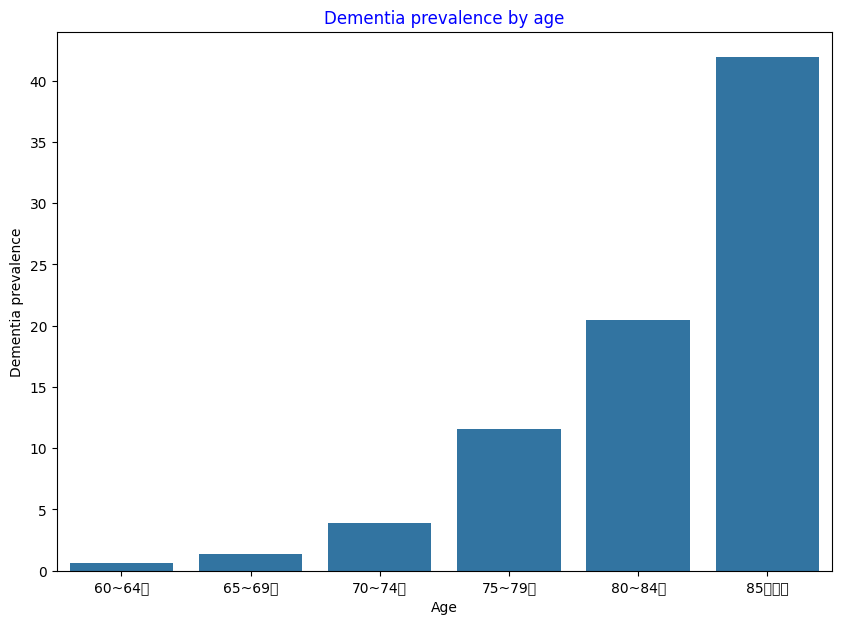

In [4]:
#겹치는 데이터 제외시키기
df = df[df['행정구역(기초)별'] != '전국']  # 각 지역과 전국이 겹치므로 전국 제외  
#60~64세, 65~69세등 '~'범위로 나타나있는 연령과 ..세이상으로 표현되어 있는 연령이 따로 있어 '~'범위로 나타나있는 연령만 선택함
df = df[df['연령별'] != '60세이상']   
df = df[df['연령별'] != '65세이상']         
#사용하지 않는 데이터 제외시키기
df = df[df['연령별'] != '남계']            
df = df[df['연령별'] != '여계']             


#연령별 치매환자유병률의 평균계산 및 정렬
top = df['치매환자유병률']
top = df.groupby('연령별')['치매환자유병률'].mean().sort_values(ascending=True) 


#데이터 시각화
plt.figure(figsize=(10,7))
sns.barplot(x=top.index,y=top.values)
plt.title('Dementia prevalence by age',color = 'blue') 
plt.xlabel('Age')  #나이
plt.ylabel('Dementia prevalence') #치매 환자 유병률
plt.show()

#데이터 스케일링
#치매환자유병률 열의 데이터를 표준화. StandardScaler를 사용하여 데이터의 평균을 0, 표준편차를 1로 만듬.
distinct = df[['치매환자유병률']]
scaler = StandardScaler()
distinct_scale = scaler.fit_transform(distinct)

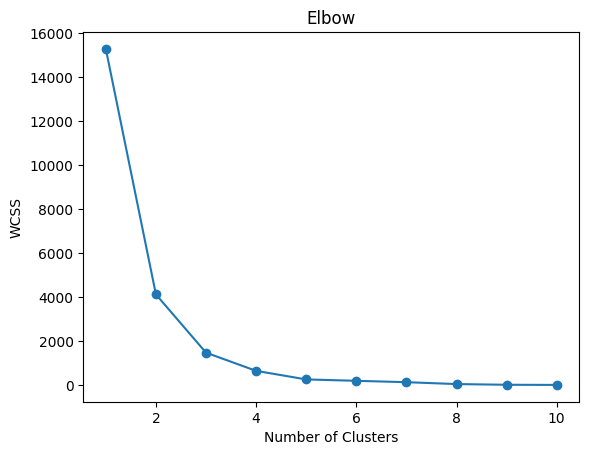

In [5]:
# 엘보우 방법을 사용하여 최적의 클러스터 수(k) 찾기
k = range(1,11) # 1부터 10까지의 클러스터 수를 테스트
wcss =[]  # WCSS값을 저장할 리스트

for i in k:  #최적의 클러스터 수(k)를 결정하기 위해 여러 k 값에 대해 클러스터링을 수행.
    kmeans = KMeans(n_clusters = i,random_state=42)# K-means 모델 생성
    kmeans.fit(distinct_scale) # 데이터에 모델 적용
    wcss.append(kmeans.inertia_) # WCSS 값을 리스트에 추가
    #클러스터 내의 데이터 포인트들이 클러스터 중심으로부터 얼마나 떨어져 있는지를 나타냄

# 엘보우 그래프 그리기: x축은 클러스터 수(k), y축은 WCSS
plt.plot(k,wcss,marker = 'o') # 선 그래프 그리기
plt.xlabel('Number of Clusters') 
plt.ylabel('WCSS')
plt.title('Elbow')
plt.show()

4.  K-means 클러스터링 적용 :
    1) 엘보우 방법으로 여러 k 값에 대한 클러스터링을 수행하고 WCSS값을 계산해 최적의 클러수터 수를 결정
     1-1) WCSS값 => 클러스터 내의 데이터 포인트들이 클러스터 중심으로부터 얼마나 떨어져 있는지 나타냄
     1-2) 엘보우 방법 => 클러스터 개수(K)를 점차 증가시키면서 클러스터링을 수행
    2) k가 4 이후부터 변화가 거의 없어 보이므로 클러스터 수(k)는 4가 적절해 보임

5. 클러스터 분석:
    1) 총 6개의 항목을 4개로 줄여야 하기 때문에 가까운 것을 찾아 클러스터링.
        
        (60~64세, 65~69세, 70~74세) # 1
        75~79세                    # 2         
        80~84세                    # 0  으로 총 4개의 군집으로 구성
        85세이상                    # 3
        



     치매환자유병률
0  35.858185
1   2.698294
2  17.380177
3  53.989929


/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


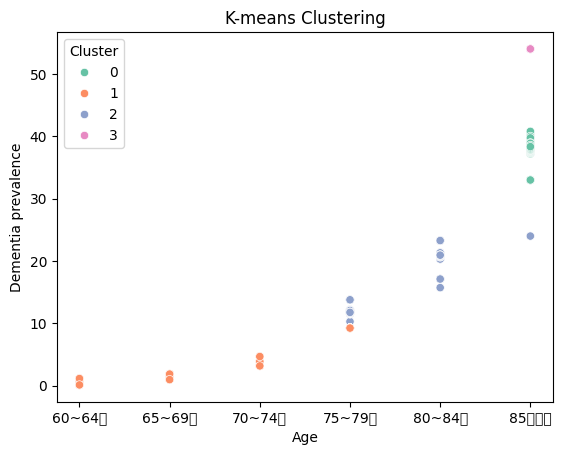

In [6]:
#k가 4이후 부터 변화가 거의 없으니 4개의 클러스터로 분류 
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(distinct) # 클러스터 할당
#각 연령별로 클러스터 할당 후 print해서 확인
df['Cluster'] = clusters  # 'Cluster' 열에 클러스터 할당 결과 저장

#클러스터의 중앙 값
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=distinct.columns)
print(cluster_centers)

# 클러스터 시각화 (산점도)
df['Cluster'] = clusters 
sns.scatterplot(x='연령별', y='치매환자유병률', data=df, hue='Cluster',palette='Set2')
plt.title('K-means Clustering')
plt.xlabel('Age')
plt.ylabel('Dementia prevalence')
plt.show()

산점도 결과를 보면 나이가 적을수록 치매유병률이 낮고 나이가 많을수록 치매유병률이 높은 것을 보면 나이가 많을수록 치매가 발병할 확률이 높다는 것을 알 수 있다.

이 높다는 것을 알 수 있다.

In [7]:
# 실루엣 점수 계산 후 출력
silhouette_mean = silhouette_score(distinct_scale, clusters)
print("실루엣 점수:", silhouette_mean)

실루엣 점수: 0.7474601447314623


6. 평가: 
    1) 실루엣 점수: 0.7474601447314623
        실루엣 점수가 (-1)~(1)까지의 값 중에 1에 가까울수록 다른 군집과 잘 분리된 0에 가까울수록 근처의 군집과 경계가 모호한 그리고 -1에 가까울수록 잘못 분류된 군집으로 구분되는데 연령별 치매환자유병률의 관계는 실루엣 점수가 약 0.75로 유의미한 관계임을 알 수 있다.